In [4]:
data = np.loadtxt('../Data/vardQ_.6f.csv',delimiter=',')

In [6]:
test_ind = np.array([ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32,
       34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66,
       68, 70, 72, 74, 76, 78, 80, 82, 83])

train_ind = np.array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33,
       35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67,
       69, 71, 73, 75, 77, 79, 81])

secondary_ind = np.array([ 84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,
        97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109,
       110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122,
       123])

In [41]:
x_train = 10**data[:, 0][train_ind]
y_train = 10**data[:, 1][train_ind]

x_test = 10**data[:, 0][test_ind]
y_test = 10**data[:, 1][test_ind]

x_stest = 10**data[:, 0][secondary_ind]
y_stest = 10**data[:, 1][secondary_ind]

[2160.00123767 1433.99950032 1073.99930419  869.99949394  787.99960538
  719.00018148  857.0003514   787.99960538  559.00024728 1017.00011024
  869.99949394  859.99910644  708.99961606  730.99936551  742.00016183
  704.00055254  616.99976696  965.99971881  701.99981875  616.00040826
  299.99982405  437.99988855  444.00003055  511.0001175   476.99958369
  482.99985458  494.0000581   461.0000792   489.00015862  527.00046693
  461.0000792   468.00015833  497.99960696  491.99988358  519.99958855
  463.00000958  478.00011379  459.00033235  428.99971138  462.000026
  487.00004349]


In [144]:
import numpy as np
from pyesmda import ESMDA, ESMDA_RS
import matplotlib.pyplot as plt


def exponential(p, x):
    """
    Simple exponential function with an amplitude and change factor.

    Parameters
    ----------
    p : tuple, list
        Parameters vector: amplitude i.e. initial value and change factor.
    x : np.array
        Independent variable (e.g. time).

    Returns
    -------
    np.array
        Result.

    """
    return p[0] + p[1]*np.exp(p[2]*x)


def forward_model(m_ensemble, x):
    """
    Wrap the non-linear observation model (forward model).

    Function calling the non-linear observation model (forward model).
    for all ensemble members and returning the predicted data for
    each ensemble member.

    Parameters
    ----------
    m_ensemble : np.array
        Initial ensemble of N_{e} parameters vector..
    x : np.array
        Independent variable (e.g. time).

    Returns
    -------
    d_pred: np.array
        Predicted data for each ensemble member.
    """
    # Initiate an array of predicted results.
    d_pred = np.zeros([m_ensemble.shape[0], x.shape[0]])
    for j in range(m_ensemble.shape[0]):
        # Calling the forward model for each member of the ensemble
        d_pred[j, :] = exponential(m_ensemble[j, :], x)
    return d_pred

In [146]:
# seed for the reproductibility
seed = 0
rng = np.random.default_rng(seed=seed)

a = 10.0
b = 2
c=-2
# timesteps
x = x_train
obs = y_train
# Initiate an ensemble of (a, b) parameters
n_ensemble = 10000  # size of the ensemble
# Uniform law for the parameter a ensemble
ma = rng.uniform(low=-10000.0, high=5000.0, size=n_ensemble)
# Uniform law for the parameter b ensemble
mb = rng.uniform(low=2, high=10000, size=n_ensemble)

# Uniform law for the parameter b ensemble
mc = rng.uniform(low=-50000, high=-1, size=n_ensemble)

# Prior ensemble
m_ensemble = np.stack((ma, mb, mc), axis=1)

# Observation error covariance matrix
cov_obs = np.diag([1.0] * obs.shape[0])

# Bounds on parameters (size m * 2)
m_bounds = np.array([[-10000.0, 5000.0], [2, 10000.0], [-50000, -1]])

# Number of assimilations
n_assimilations = 30

# Use a geometric suite (see procedure un evensen 2018) to compte alphas.
# Also explained in Torrado 2021 (see her PhD manuscript.)
cov_obs_inflation_geo = 1.2
cov_obs_inflation_factors = [1.1]
for l in range(1, n_assimilations):
    cov_obs_inflation_factors.append(
        cov_obs_inflation_factors[l - 1] / cov_obs_inflation_geo
    )
scaling_factor: float = np.sum(1 / np.array(cov_obs_inflation_factors))
cov_obs_inflation_factors = [
    alpha * scaling_factor for alpha in cov_obs_inflation_factors
]

np.testing.assert_almost_equal(sum(1.0 / np.array(cov_obs_inflation_factors)), 1.0)

# This is just for the test
cov_mm_inflation_factors= [1.2] * n_assimilations

solver = ESMDA(
    obs,
    m_ensemble,
    cov_obs,
    forward_model,
    forward_model_args=(x,),
    forward_model_kwargs={},
    n_assimilations=n_assimilations,
    cov_obs_inflation_factors=cov_obs_inflation_factors,
    cov_mm_inflation_factors=cov_mm_inflation_factors,
    m_bounds=m_bounds,
    save_ensembles_history=True,
    seed=seed
)
# Call the ES-MDA solver
solver.solve()

# Assert that the parameters are found with a 5% accuracy.
#assert np.isclose(np.average(solver.m_prior, axis=0), np.array([a, b]), rtol=5e-2).all()

# Get the approximated parameters
a_approx, b_approx, c_approx = np.average(solver.m_prior, axis=0)

# Get the uncertainty on the parameters
a_std, b_std, c_std = np.sqrt(np.diagonal(solver.cov_mm))


print(f"a = {a_approx:.5f} +/- {a_std:.4E}")
print(f"b = {b_approx:.5f} +/- {b_std: 4E}")
print(f"c = {c_approx:.5f} +/- {c_std: 4E}")

Assimilation # 1
Assimilation # 2
Assimilation # 3
Assimilation # 4
Assimilation # 5
Assimilation # 6
Assimilation # 7
Assimilation # 8
Assimilation # 9
Assimilation # 10
Assimilation # 11
Assimilation # 12
Assimilation # 13
Assimilation # 14
Assimilation # 15
Assimilation # 16
Assimilation # 17
Assimilation # 18
Assimilation # 19
Assimilation # 20
Assimilation # 21
Assimilation # 22
Assimilation # 23
Assimilation # 24
Assimilation # 25
Assimilation # 26
Assimilation # 27
Assimilation # 28
Assimilation # 29
Assimilation # 30
a = 503.32470 +/- 4.4803E-01
b = 1842.05847 +/-  2.256063E+00
c = -15114.24136 +/-  2.612038E+01


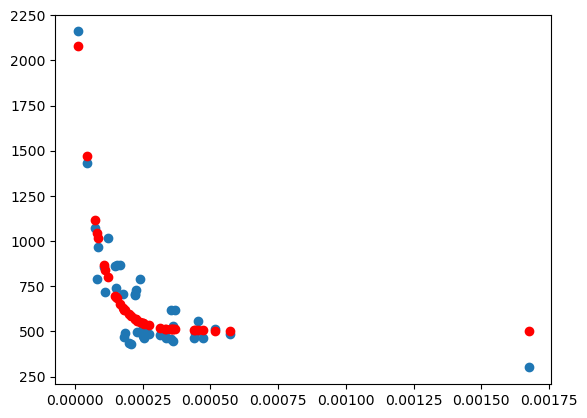

In [147]:
plt.scatter(x_train, y_train)
plt.scatter(x_train, a_approx + b_approx*np.exp(c_approx*x_train), color="red")

In [148]:
print("RMSE: ", np.sqrt(np.average(((a_approx + b_approx*np.exp(c_approx*x_test)) - y_test)**2)))

RMSE:  133.2239794327999


In [149]:
print("RMSE: ", np.sqrt(np.average(((a_approx + b_approx*np.exp(c_approx*x_stest)) - y_stest)**2)))

RMSE:  233.54029584397816


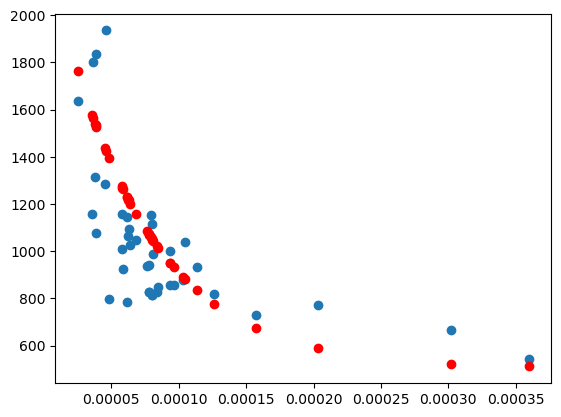

In [150]:
plt.scatter(x_stest, y_stest)
plt.scatter(x_stest, a_approx + b_approx*np.exp(c_approx*x_stest), color="red")